# In situ kinetic analysis of glyoxalase I and glyoxalase II in Saccharomyces cerevisiae  
## (Martins AM et al., 2001)

### Abstract
The kinetics of glyoxalase I [(R)-S-lactoylglutathione methylglyoxal-lyase; EC 4.4.1.5] and glyoxalase II (S-2-hydroxyacylglutathione hydrolase; EC 3.1.2.6) from Saccharomyces cerevisiae was studied in situ, in digitonin permeabilized cells, using two different approaches: initial rate analysis and progress curves analysis. Initial rate analysis was performed by hyperbolic regression of initial rates using the program hyperfit. Glyoxalase I exhibited saturation kinetics on 0.05–2.5 mm hemithioacetal concentration range, with kinetic parameters Km 0.53 ± 0.07 mm and V (3.18 ± 0.16) × 10−2 mm·min−1. Glyoxalase II also showed saturation kinetics in the Sd-lactoylglutathione concentration range of 0.15–3 mm and Km 0.32 ± 0.13 mm and V (1.03 ± 0.10) × 10−3 mm·min−1 were obtained. The kinetic parameters of both enzymes were also estimated by nonlinear regression of progress curves using the raw absorbance data and integrated differential rate equations with the program gepasi. Several optimization methods were used to minimize the sum of squares of residuals. The best parameter fit for the glyoxalase I reaction was obtained with a single curve analysis, using the irreversible Michaelis–Menten model. The kinetic parameters obtained, Km 0.62 ± 0.18 mm and V (2.86 ± 0.01) × 10−2 mm·min−1, were in agreement with those obtained by initial rate analysis. The results obtained for glyoxalase II, using either the irreversible Michaelis–Menten model or a phenomenological reversible hyperbolic model, showed a high correlation of residuals with time and/or high values of standard deviation associated with Km. The possible causes for the discrepancy between data obtained from initial rate analysis and progress curve analysis, for glyoxalase II, are discussed.

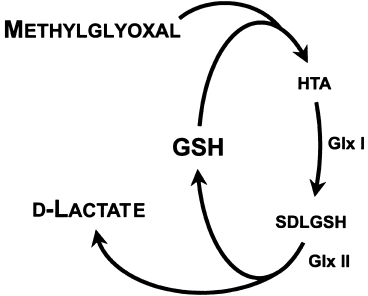

# ⚠️ Here we use a modified version of the model in which:

## 👉 The modifiers are removed; 

## 👉 The species are annotated;

## 👉 Reaction vGlxII is removed because of its incompatible format;

## 👉 SBO terms were added for each reaction to determine the type of rate law.
Note: Since Level 2 Version 2, SBML has incorporated a specific attribute, sboTerm, specifically for the purpose of linking SBO term annotations with model components. The current model was built under Level 2 Version 1.0. We changed this to Level 2 version 2 to include the SBO terms.


# ⚠️ Here would be the modified model:

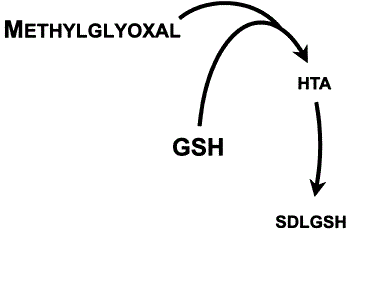

In [1]:
## Libraries:

# a) Bond graphs
import BondGraphTools as bgt

# b) Data extraction
from pyomexmeta import RDF, eUriType
import os
import sys
import xml.etree.ElementTree as ET
import rdflib
from lxml import etree
import re

# c) General
import copy
import difflib
import numpy as np
import pandas as pd
import math
import operator as op
import ast
import re

# d) Plot
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.font_manager as font_manager
import matplotlib.colors
from pylab import rcParams
import matplotlib.image as mpimg

# sbml
from libsbml import*
import simplesbml 

# Integration and fitting
from scipy.optimize import curve_fit, minimize, least_squares, newton_krylov, basinhopping
from scipy  import integrate
import scipy.stats as stats
from symfit import parameters, variables, log, Fit, GreaterThan, Model
from symfit.core.minimizers import BasinHopping


The tests rely on tellurium to construct the models
Since tellurium is not installed the tests can't be run
If you want to run the tests, pip install tellurium first


In [2]:
simulations = ['/Users/nsha457/Documents/Jupyter_files/SBML_AnnotMerge/MODEL6624199343_reversibleMM/solutionsReversibleMM.csv']  
locations=['/Users/nsha457/Documents/Jupyter_files/SBML_AnnotMerge/MODEL6624199343_reversibleMM/MODEL6624199343.xml']


In [3]:
def watchdog(idAndAnnotations):
    
    # Finding identical annotations among the entities (should return Null)
    checkSimilarities = True
    for i in range(len(idAndAnnotations.keys())):
        for j in range(i+1,len(idAndAnnotations.keys())):
            if idAndAnnotations[list(idAndAnnotations)[i]] == idAndAnnotations[list(idAndAnnotations)[j]]:
                print("Pairs with identical annotations in the same model: ",list(idAndAnnotations)[i],list(idAndAnnotations)[j])
                print('----------')
                print('Change the annotations of the entities/their compartment to be distinctive.')
                checkSimilarities = False

                img = mpimg.imread('Watchdog.jpg')
                imgplot = plt.imshow(img)
                plt.show()
                
    return checkSimilarities

In [4]:
# Reading and extracting annotations from the sbml files

def annotationExtraction(address,model_lib):

    modelURI = SBase.getURI(model_lib) 

    root=ET.parse(open(address)).getroot()
    idAndAnnotations = {}
    compartments=[]
    for child in root:
        for grand in child:
            if grand.tag == '{'+str(modelURI)+'}'+'listOfCompartments':
                for g in grand:
                    for g1 in g:
                        for g2 in g1:
                            for g3 in g2:
                                for g4 in g3:
                                    for g5 in g4:
                                        for g6 in g5:
                                            compartments.append((g.attrib.get('id'),g6.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}resource')))



            if grand.tag == '{'+str(modelURI)+'}'+'listOfSpecies':
                for g in grand: 
                    idAndAnnotations[g.attrib.get('id')] = []
                    for i,j in compartments:
                        if g.attrib.get('compartment') == i:
                            idAndAnnotations[g.attrib.get('id')].append(j)
                    for g1 in g:
                        for g2 in g1:
                            for g3 in g2:
                                for g4 in g3:
                                    for g5 in g4:
                                        for g6 in g5:
                                            idAndAnnotations[g.attrib.get('id')].append(g6.get('{http://www.w3.org/1999/02/22-rdf-syntax-ns#}resource'))
  
    checkSimilarities = watchdog(idAndAnnotations)
    
    if checkSimilarities == True:                                    
        return[compartments,idAndAnnotations]
    else:
        return


In [5]:
def reactionsCategorizing(model_lib,model_simple,compartments,idAndAnnotations):
    
    reaction_reactants={}; reaction_products={}; Synthesis=[]; Dtype=[]

    for reaction in model_simple.getListOfReactionIds():
        reaction_reactants[reaction]=[]
        reaction_products[reaction]=[]

        reactNum=model_simple.getNumReactants(reaction)
        prodNum=model_simple.getNumProducts(reaction)

        if reactNum is 0:
            Synthesis.append(reaction)
        if prodNum is 0:
            Dtype.append(reaction)


        for i in range(reactNum):
            for name,identifier in compartments:
                if idAndAnnotations[model_simple.getReactant(reaction, i)] ==  [str(identifier)]:  # if a component has no annotation but the one for any of the compartments, don't use its annotation
                    reaction_reactants[reaction].append((model_simple.getReactantStoichiometry(reaction, i), \
                                                 model_simple.getReactant(reaction, i)))
                    break
                else:
                    reaction_reactants[reaction].append((model_simple.getReactantStoichiometry(reaction, i), \
                                                         idAndAnnotations[model_simple.getReactant(reaction, i)]))
                    break


        for ii in range(prodNum):
            for name,identifier in compartments:
                if idAndAnnotations[model_simple.getProduct(reaction, ii)] ==  [str(identifier)]:  # if a component has no annotation but the one for any of the compartments, don't use its annotation
                    reaction_products[reaction].append((model_simple.getProductStoichiometry(reaction, ii), \
                                                 model_simple.getProduct(reaction, ii)))
                    break
                else:
                    reaction_products[reaction].append((model_simple.getProductStoichiometry(reaction, ii), \
                                                         idAndAnnotations[model_simple.getProduct(reaction, ii)]))
                    break
            


    reversibles=[]; irreversibles=[]; 
    for (reaction,r) in zip(model_simple.getListOfReactionIds(),range(len(model_lib.getListOfReactions()))):

        if model_lib.getListOfReactions()[r].getReversible() is True:
            reversibles.append(reaction)
        elif reaction not in [synth for synth in Synthesis] and reaction not in [d for d in Dtype]:
            irreversibles.append(reaction)  

 
    speciesId=[]
    for species in model_simple.getListOfAllSpecies():
        for reaction in reversibles+irreversibles:
            for stoichiometry,reactant in reaction_reactants[reaction]:
                if species in [x for x in idAndAnnotations if idAndAnnotations[x]==reactant] and species not in [d for d in speciesId]:
                    speciesId.append(species)

            for stoichiometry,product in reaction_products[reaction]:
                if species in [x for x in idAndAnnotations if idAndAnnotations[x]==product] and species not in [d for d in speciesId]:
                    speciesId.append(species)


    return [speciesId,reversibles,irreversibles,reaction_reactants,reaction_products,Synthesis,Dtype]

In [6]:
# Unifying all the concentrations into micro Mole (uM)

def unitConversion(solutions):
    print('Enter the unit for concentration in the model ("pM, nM, uM, mM, M"): ')
    print('***Units will be all converted to uM. Enter "n" to keep the original unit***')
    unit=str(input())
    
    print('Enter a normalisation factor for concentration ("enter 1 if you wish no normalisation"): ')
    normalisationFactor = float(input())
    
    if unit == "M" or unit == "m":
        unit = "M"
        for column in solutions:
            if column != 'Time' and column != 'compartment':
                solutions[column]=solutions[column].apply(lambda x: x*1e6*normalisationFactor)
    if unit == "mM" or unit == "mm":
        unit = "mM"
        for column in solutions:
            if column != 'Time' and column != 'compartment':
                solutions[column]=solutions[column].apply(lambda x: x*1e3*normalisationFactor)
    if unit == "uM" or unit == "um":
        unit = "uM"
        for column in solutions:
            if column != 'Time' and column != 'compartment':
                solutions[column]=solutions[column].apply(lambda x: x*normalisationFactor)
    if unit == "nM" or unit == "nm":
        unit = "nM"
        for column in solutions:
            if column != 'Time' and column != 'compartment':
                solutions[column]=solutions[column].apply(lambda x: x*1e-3*normalisationFactor)
    if unit == "pM" or unit == "pm":
        unit = "pM"
        for column in solutions:
            if column != 'Time' and column != 'compartment':
                solutions[column]=solutions[column].apply(lambda x: x*1e-6*normalisationFactor)
                
    if unit=='uM' or unit=='n':
        print('No unit conversion was required for this model and normalised by a factor of ',normalisationFactor)
    else:
        print('Units converted from ',unit,' to uM and normalised by a factor of ',normalisationFactor)
        
    print('\n \n')
        
    return solutions
        

In [7]:
listOfComponents={}; listOfConnections={}; idAndAnnotationsAll={}; solutionsAll={};
i=0
for address,simulation in zip(locations,simulations):

    reader = SBMLReader()
    document = reader.readSBML(address)
    error = document.getNumErrors()

    if error:            
        print("Error found in ",address)
        break

    else:          
        model_lib = document.getModel()
        model_simple = simplesbml.loadSBMLFile(address)
        unifiedSolution = unitConversion(pd.read_csv(simulation))

        [compartments,idAndAnnotations] = annotationExtraction(address,model_lib)

        [speciesId,reversibles,irreversibles,reaction_reactants,reaction_products,Synthesis,Dtype] = reactionsCategorizing(model_lib,model_simple,compartments,idAndAnnotations)            



Enter the unit for concentration in the model ("pM, nM, uM, mM, M"): 
***Units will be all converted to uM. Enter "n" to keep the original unit***
n
Enter a normalisation factor for concentration ("enter 1 if you wish no normalisation"): 
1
No unit conversion was required for this model and normalised by a factor of  1.0

 



In [8]:
compartments

[('compartment', 'http://identifiers.org/go/GO:0005622')]

In [9]:
speciesId

['GSH', 'HTA', 'SLG', 'MG']

In [10]:
idAndAnnotations

{'GSH': ['http://identifiers.org/go/GO:0005622',
  'http://identifiers.org/chebi/CHEBI:16856'],
 'HTA': ['http://identifiers.org/go/GO:0005622',
  'http://identifiers.org/chebi/CHEBI:131710'],
 'SLG': ['http://identifiers.org/go/GO:0005622',
  'http://identifiers.org/chebi/CHEBI:15694'],
 'Lac': ['http://identifiers.org/go/GO:0005622',
  'http://identifiers.org/chebi/CHEBI:16004'],
 'MG': ['http://identifiers.org/go/GO:0005622',
  'http://identifiers.org/chebi/CHEBI:17158']}

In [11]:
reversibles

['vneHTA', 'vGlxI']

In [12]:
irreversibles

[]

In [13]:
reaction_reactants

{'vneHTA': [(1.0,
   ['http://identifiers.org/go/GO:0005622',
    'http://identifiers.org/chebi/CHEBI:17158']),
  (1.0,
   ['http://identifiers.org/go/GO:0005622',
    'http://identifiers.org/chebi/CHEBI:16856'])],
 'vGlxI': [(1.0,
   ['http://identifiers.org/go/GO:0005622',
    'http://identifiers.org/chebi/CHEBI:131710'])]}

In [14]:
reaction_products

{'vneHTA': [(1.0,
   ['http://identifiers.org/go/GO:0005622',
    'http://identifiers.org/chebi/CHEBI:131710'])],
 'vGlxI': [(1.0,
   ['http://identifiers.org/go/GO:0005622',
    'http://identifiers.org/chebi/CHEBI:15694'])]}

In [15]:
model_lib.getListOfReactions()[0]

<Reaction vneHTA>

In [44]:
def allReversible(model_lib,model_simple,speciesId,reversibles,reaction_reactants,reaction_products,solutions,idAndAnnotations):
    
    reversibleMA = []
    reversibleMM = []
    Kp_to_Kr = []
    for (reaction,r) in zip(model_simple.getListOfReactionIds(),range(len(model_lib.getListOfReactions()))):
        
        if SBase.getSBOTermID(model_lib.getListOfReactions()[r]) == 'SBO:0000079':
#             print(reaction,SBase.getSBOTermID(model_lib.getListOfReactions()[r]))
            reversibleMA.append(reaction)

            phi_Xr_1 = 1
            phi_Xp_1 = 1
            phi_Xr_e = 1
            phi_Xp_e = 1

            for stoichiometry,reactant in reaction_reactants[reaction]:

                phi_Xr_1 = phi_Xr_1 * solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]][1]
                phi_Xr_e = phi_Xr_e * solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]][len(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]])-1]

            for stoichiometry,product in reaction_products[reaction]:        
                phi_Xp_1 = phi_Xp_1 * solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]][1]
                phi_Xp_e = phi_Xp_e * solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]][len(solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]])-1]

            # compartment for a reactant/species in the reaction
            compartmentId1 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0])
            compartmentId2 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==product][0])
            compartmentVolume1 = model_simple.getCompartmentVolume(compartmentId1)
            compartmentVolume2 = model_simple.getCompartmentVolume(compartmentId2)

            sigma = solutions[reaction][len(solutions[reaction])-1] / solutions[reaction][1]
            Kp_to_Kr.append((compartmentVolume1*(sigma*phi_Xr_1 - phi_Xr_e))/(compartmentVolume2*(sigma*phi_Xp_1 - phi_Xp_e)))

        
        
        if SBase.getSBOTermID(model_lib.getListOfReactions()[r]) == 'SBO:0000438':
#             print(reaction,SBase.getSBOTermID(model_lib.getListOfReactions()[r]))
            reversibleMM.append(reaction)

            reactantsSpecies=[]
            productsSpecies=[]


            solve=tuple()

            for stoichiometry,reactant in reaction_reactants[reaction]:
                reactantsSpecies.append(reactant)        
                solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],stoichiometry),)


            for stoichiometry,product in reaction_products[reaction]:
                productsSpecies.append(product)        
                solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]],stoichiometry),)



            # compartment for a reactant/species in the reaction
            compartmentId1 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0])
            compartmentId2 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==product][0])
            compartmentVolume1 = model_simple.getCompartmentVolume(compartmentId1)
            compartmentVolume2 = model_simple.getCompartmentVolume(compartmentId2)


            def func(X,param1,param2,param3,param4,param5):

                reactants = np.ones((len(unifiedSolution['Time'])))
                products= np.ones((len(unifiedSolution['Time'])))


                for x in range(0,len(reactantsSpecies)):
                    reactants = reactants * X[x]            

                for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
                    products = products * X[x]


                v = ((param1*reactants)-(param2*products))/(param3+(param4*reactants)+(param5*products))

                return v


            bounds=[[0,0,0,0,0],[np.inf,np.inf,np.inf,np.inf,np.inf]]
            popt, pcov = curve_fit(func,solve,unifiedSolution[reaction], maxfev=300000, bounds=bounds)
            
            for i in range(len(popt)):
                Kp_to_Kr.append(popt[i])


    trueValues = copy.deepcopy(Kp_to_Kr) 

    rowM=[]
    for s in speciesId:
         rowM.append([x for x in idAndAnnotations.values() if idAndAnnotations[s]==x][0])
    
    for reaction in reversibleMM:
        rowM = rowM + [reaction+'_r1']
        rowM = rowM + [reaction+'_r2']
        rowM = rowM + [reaction+'_E']
        rowM = rowM + [reaction+'_ES']
        rowM = rowM + [reaction+'_E0']

    # M initial (regarding the steady-state ratios obtained in the previous stage)

    M = np.zeros([len(trueValues),len(rowM)]) 


    

    for i,reaction in zip(range(len(reversibleMA)),reversibleMA):
        
        for stoichiometry,reactant in reaction_reactants[reaction]:
            for row in range(len(rowM)):     
                if rowM[row] == reactant:  
                    M[i][row] = -stoichiometry



        for stoichiometry,product in reaction_products[reaction]:
            for row in range(len(rowM)):     
                if rowM[row] == product:                    
                    M[i][row] = stoichiometry
                    
    lastline = copy.deepcopy(i+1)
    
    for i,reaction in zip(range(lastline,lastline+5*len(reversibleMM),5),reversibleMM):
        
        # Each MM reaction in BG has 5 parameters 
        for row in range(len(rowM)):
            if rowM[row] == reaction+'_r1' or rowM[row] == reaction+'_r2' or rowM[row] == reaction+'_E' \
            or rowM[row] == reaction+'_E0': 
                M[i][row] = 1
            for stoichiometry,reactant in reaction_reactants[reaction]:
                if rowM[row] == reactant:
                    M[i][row] = stoichiometry
                    
                
            if rowM[row] == reaction+'_r1' or rowM[row] == reaction+'_r2' or rowM[row] == reaction+'_E' \
            or rowM[row] == reaction+'_E0' : 
                M[i+1][row] = 1
            for stoichiometry,product in reaction_products[reaction]:
                if rowM[row] == product:
                    M[i+1][row] = stoichiometry
                    
                    
            if rowM[row] == reaction+'_r1' or rowM[row] == reaction+'_r2': 
                M[i+2][row] = 1
                
                
            if rowM[row] == reaction+'_r1' or rowM[row] == reaction+'_E': 
                M[i+3][row] = 1
            if rowM[row] == reaction+'_ES': 
                M[i+3][row] = -1
            for stoichiometry,reactant in reaction_reactants[reaction]:
                if rowM[row] == reactant:
                    M[i+3][row] = stoichiometry
                    
                    
            if rowM[row] == reaction+'_r2' or rowM[row] == reaction+'_E': 
                M[i+4][row] = 1
            if rowM[row] == reaction+'_ES': 
                M[i+4][row] = -1
            for stoichiometry,product in reaction_products[reaction]:
                if rowM[row] == product:
                    M[i+4][row] = stoichiometry
                    
            
            

             


    logTrueValues = [];

    for k in trueValues:
        logTrueValues.append(math.log(k))

    logTrueValues = np.array(logTrueValues)


    Mpinv = np.linalg.pinv(np.array(M))
    logU = Mpinv.dot(logTrueValues)

    thermodynamics = [math.exp(i) for i in list(logU)]
    
    for i,j in zip(rowM,thermodynamics):
        print(i,' : ',j)
        

  
    
    
    return [rowM,thermodynamics,reversibleMA,reversibleMM]

In [45]:
[rowM,thermodynamics,reversibleMA,reversibleMM]=allReversible(model_lib,model_simple,speciesId,reversibles,reaction_reactants,reaction_products,unifiedSolution,idAndAnnotations)

['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:16856']  :  2.9602574169533145
['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:131710']  :  26.03163298345209
['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15694']  :  0.007441665833185781
['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:17158']  :  2.960257416953305
vGlxI_r1  :  1.2650668776735976
vGlxI_r2  :  8020.010108426601
vGlxI_E  :  0.5734572591958539
vGlxI_ES  :  0.0067334717994458095
vGlxI_E0  :  0.0038613582829827887


In [46]:
# Finding the reaction rate constants (reversible MA reactions)

reactionRates = {}
for reaction in  reversibleMA:

    reactantsSpecies=[]
    productsSpecies=[]

    K_reactants = 1
    K_products = 1

    solve=tuple()

    for stoichiometry,reactant in reaction_reactants[reaction]:
        reactantsSpecies.append(reactant)        
        solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == reactant:
                K_reactants = K_reactants * pow(thermodynamics[i],stoichiometry)   


    for stoichiometry,product in reaction_products[reaction]:
        productsSpecies.append(product)        
        solve=solve+(pow(unifiedSolution[[x for x in idAndAnnotations if idAndAnnotations[x]==product][0]],stoichiometry),)

        for i in range(len(rowM)):
            if rowM[i] == product:
                K_products = K_products * pow(thermodynamics[i],stoichiometry)

    # compartment for a reactant/species in the reaction
    compartmentId1 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0])
    compartmentId2 = model_simple.getCompartmentIdSpeciesIsIn([x for x in idAndAnnotations if idAndAnnotations[x]==product][0])
    compartmentVolume1 = model_simple.getCompartmentVolume(compartmentId1)
    compartmentVolume2 = model_simple.getCompartmentVolume(compartmentId2)


    def func(X, r):


        reactants = np.ones((len(unifiedSolution['Time'])))
        products= np.ones((len(unifiedSolution['Time'])))


        for x in range(0,len(reactantsSpecies)):
            reactants = reactants * X[x]            

        for x in range(len(reactantsSpecies),len(reactantsSpecies)+len(productsSpecies)):
            products = products * X[x]


        v = r*(compartmentVolume1*K_reactants*reactants- compartmentVolume2*K_products*products)


        return v

    bounds=[[0],[np.inf]]
    popt, pcov = curve_fit(func,solve,unifiedSolution[reaction], maxfev=300000, bounds=bounds)
    if popt[0]==1: 
        popt, pcov = curve_fit(func,solve,unifiedSolution[reaction], maxfev=300000, method='lm')

    reactionRates[reaction]=popt[0]




In [47]:
reactionRates

{'vneHTA': 0.03879894904197863}

In [48]:
param1 = thermodynamics[8]*thermodynamics[4]*thermodynamics[5]*thermodynamics[6]*thermodynamics[1]
param2 = thermodynamics[8]*thermodynamics[4]*thermodynamics[5]*thermodynamics[6]*thermodynamics[2]
param3 = thermodynamics[4]+thermodynamics[5]
param4 = thermodynamics[4]*thermodynamics[6]*thermodynamics[1]/thermodynamics[7]
param5 = thermodynamics[5]*thermodynamics[6]*thermodynamics[2]/thermodynamics[7]

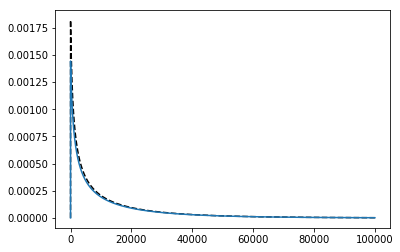

In [49]:
v_approx = ((param1*unifiedSolution['HTA'])-(param2*unifiedSolution['SLG']))/(param3+(param4*unifiedSolution['HTA'])+(param5*unifiedSolution['SLG']))
plt.plot(unifiedSolution['Time'],v_approx,'k--')
plt.plot(unifiedSolution['Time'],unifiedSolution['vGlxI'])

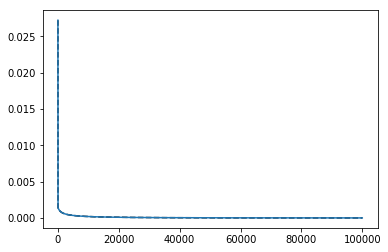

In [50]:
v_approx = reactionRates['vneHTA']*(thermodynamics[3]*thermodynamics[0]*unifiedSolution['MG']*unifiedSolution['GSH']- thermodynamics[1]*unifiedSolution['HTA'])
plt.plot(unifiedSolution['Time'],v_approx,'k--')
plt.plot(unifiedSolution['Time'],unifiedSolution['vneHTA'])

In [78]:
reversibleMM

['vGlxI']

In [84]:
BGreactions

[R: vneHTA, R: vGlxI_r1, R: vGlxI_r2]

In [129]:
def BGconstruction(compartments,idAndAnnotations,reversibles,irreversibles,reversibleMA,reversibleMM,reaction_reactants,reaction_products,speciesId,solutions,reactionRates,thermodynamics,rowM,Synthesis,Dtype):
    
    idealGassConstant=8.314
    T= 310
    
    BGspecies=[]; BGzeroJunc=[]; BGreactions=[]; oneJunc_reac=[]; oneJunc_prod=[]; TF=[];

    for reaction in reversibleMA: 

        BGreactions.append(bgt.new("Re", name=reaction, library="BioChem", value={'R':idealGassConstant, 'T':T}))

        oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction)) 
        oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction))


        for stoichiometry,reactant in reaction_reactants[reaction]:
            if stoichiometry != 1:
                TF.append(bgt.new('TF', name='oneReac '+reaction+' '+str(reactant), value=stoichiometry))

        for stoichiometry,product in reaction_products[reaction]:
            if stoichiometry != 1:
                TF.append(bgt.new('TF', name='oneProd '+reaction+' '+str(product), value=1/stoichiometry))

#         if reaction in irreversibleMA:
#             BGspecies.append(bgt.new("Ce_S", name=reaction+' X', library="BioChem", value={'R':idealGassConstant, 'T':T}))
#             BGzeroJunc.append(bgt.new("0", name=reaction+' X'))  
            

    for reaction in reversibleMM:
        
        BGreactions.append(bgt.new("Re", name=reaction+'_r1', library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGreactions.append(bgt.new("Re", name=reaction+'_r2', library="BioChem", value={'R':idealGassConstant, 'T':T}))
        
        oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction+'_r1')) 
        oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction+'_r1'))
        oneJunc_reac.append(bgt.new("1", name='oneReac '+reaction+'_r2')) 
        oneJunc_prod.append(bgt.new("1", name='oneProd '+reaction+'_r2'))
        
        # For now, no stoichiometry for species in Michaelis-Menten!
        
        
        BGspecies.append(bgt.new("Ce", name=reaction+'_E', library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=reaction+'_E')) 
        BGspecies.append(bgt.new("Ce", name=reaction+'_ES', library="BioChem", value={'R':idealGassConstant, 'T':T}))
        BGzeroJunc.append(bgt.new("0", name=reaction+'_ES')) 
        


    for species in speciesId:
        
        for name,identifier in compartments:
            if idAndAnnotations[species] ==  [str(identifier)]:  # if a component has no annotation but the one for any of the compartments, don't use its annotation
                speciesAnnotated = copy.deepcopy(species)
                break
            else:
                speciesAnnotated = copy.deepcopy(idAndAnnotations[species])

        diff = solutions[species].diff() 
        diff.fillna(method='bfill', inplace=True)
        
        if diff.all() != 0:
            BGspecies.append(bgt.new("Ce", name=speciesAnnotated, library="BioChem", value={'R':idealGassConstant, 'T':T}))
            BGzeroJunc.append(bgt.new("0", name=speciesAnnotated)) 
            
        elif diff.all() == 0:
            BGspecies.append(bgt.new("Ce_S", name=speciesAnnotated, library="BioChem", value={'R':idealGassConstant, 'T':T}))
            BGzeroJunc.append(bgt.new("0", name=speciesAnnotated)) 
            


            
    # Setting the values in BGs

    for BGreaction in BGreactions: # works for reversible and irreversible MAs
        if BGreaction.name in [key for key in reactionRates]:
            bgt.set_param(BGreaction,'r',reactionRates[BGreaction.name])
    
    for r in range(len(rowM)):
        for BGreaction in BGreactions: # works for reversible and irreversible MMs
            if rowM[r] == BGreaction.name:
                bgt.set_param(BGreaction,'r',thermodynamics[r])


    for bg in BGspecies:  
        for i in range(len(rowM)):
            for name,identifier in compartments:
                if rowM[i] ==  [str(identifier)]:
                    if bg.name == rowM[i]:
                        bgt.set_param(bg,'k',thermodynamics[i])     

                    break
                elif bg.name ==  rowM[i]:
                    bgt.set_param(bg,'k',thermodynamics[i]) 


    for reaction in irreversibles:
        for bg in BGspecies: 
            if bg.name == reaction+' X':
                for i in range(len(rowM)):
                    if rowM[i] == reaction+' X':
                        bgt.set_param(bg,'k',thermodynamics[i])
    
    
            
# connections
    connections = []

    for z in BGzeroJunc:
        for s in BGspecies:
            if (z.name) == (s.name):
                connections.append([z,s])


    for r in BGreactions:
        for oneR,oneP in zip(oneJunc_reac,oneJunc_prod):    
            if 'oneReac '+r.name == oneR.name:
                connections.append([oneR,r])

            if 'oneProd '+r.name == oneP.name:
                connections.append([r,oneP])



    for reaction in reversibleMA :  # later we can add "irreversibleMA". need to categorize irreversibles too
        for oneR in oneJunc_reac:
            for xR in oneR.name.split(sep=" "):
                if (reaction) == (xR):

                    for z in BGzeroJunc:
                        for stoichiometry,reactant in reaction_reactants[reaction]:
                            if  z.name == reactant:
                                if stoichiometry!=1:
                                    for TFcomp in TF:
                                        if TFcomp.name == 'oneReac '+reaction+' '+str(reactant):
                                            connections.append([z,(TFcomp,0)])
                                            connections.append([(TFcomp,1),oneR])
                                else:
                                    connections.append([z,oneR])


        for oneP in oneJunc_prod:
            for xP in oneP.name.split(sep=" "):
                if (reaction) == (xP):

                    for z in BGzeroJunc:
                        for stoichiometry,product in reaction_products[reaction]:
                            if z.name == product:
                                if stoichiometry!=1:
                                    for TFcomp in TF:
                                        if TFcomp.name == 'oneProd '+reaction+' '+str(product):
                                            connections.append([oneP,(TFcomp,0)])
                                            connections.append([(TFcomp,1),z])
                                else:
                                    connections.append([oneP,z])

#   if reaction in irreversibleMA:
                                
                                
                                
    for reaction in reversibleMM :  # later we can add "irreversibleMM". need to categorize irreversibles too
        for oneR in oneJunc_reac:
            for xR in oneR.name.split(sep=" "):
                if (reaction+'_r1') == (xR):
                    
                    for z in BGzeroJunc:
                        for stoichiometry,reactant in reaction_reactants[reaction]:
                            if  z.name == reactant:
                                if stoichiometry!=1:
                                    for TFcomp in TF:
                                        if TFcomp.name == 'oneReac '+reaction+'_r1'+' '+str(reactant):
                                            connections.append([z,(TFcomp,0)])
                                            connections.append([(TFcomp,1),oneR])
                                else:
                                    connections.append([z,oneR])
                                    
                        if z.name == reaction+'_E':
                                connections.append((z,oneR))
                                    
                if (reaction+'_r2') == (xR):  # the Intermediate product to the Re:r2 (one-junc)                                        
                    for z in BGzeroJunc:
                        if z.name == reaction+'_ES':
                                connections.append((z,oneR))
                        
                                    
        for oneP in oneJunc_prod:
            for xP in oneP.name.split(sep=" "):
                if (reaction+'_r2') == (xP):

                    for z in BGzeroJunc:
                        for stoichiometry,product in reaction_products[reaction]:
                            if z.name == product:
                                if stoichiometry!=1:
                                    for TFcomp in TF:
                                        if TFcomp.name == 'oneProd '+reaction+'_r2'+' '+str(product):
                                            connections.append([oneP,(TFcomp,0)])
                                            connections.append([(TFcomp,1),z])
                                else:
                                    connections.append([oneP,z])
                                    
                        if z.name == reaction+'_E':
                                connections.append((oneP,z))
                                    
                                    
                if (reaction+'_r1') == (xP):  # the Intermediate product to the Re:r1 (one-junc)                                        
                    for z in BGzeroJunc:
                        if z.name == reaction+'_ES':
                                connections.append((oneP,z))

##  for reaction in irreversibleMM:

                                                            
                                
                                
# Adding the boundary conditions of Sf/Se the model for Synthesis/Dtype(Degradation,Decay )

   
#     for reaction in Dtype:
#         for stoichiometry,reactant in reaction_reactants[reaction]:
#             for  i in range(len(rowM)):
#                 if rowM[i] == reactant:
#                     K_reactants = thermodynamics[i]


#         def funcDtype(X, r):

#             products= np.ones((len(solutions['Time'])))          


#             v = r*(K_reactants*X - (0.001*K_reactants)*products)

#             return v

#         bounds=[[0],[np.inf]]
#         popt, pcov = curve_fit(funcDtype,solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],solutions[reaction], maxfev=5000, bounds=bounds)
#         if popt[0]==1:
#             popt, pcov = curve_fit(funcDtype,solutions[[x for x in idAndAnnotations if idAndAnnotations[x]==reactant][0]],solutions[reaction], maxfev=5000, method='lm')

#         rateDtype = popt[0]


#         BGreactions.append(bgt.new("Re", name=reaction, library="BioChem", value={'r':rateDtype ,'R':idealGassConstant, 'T':T}))

#         for bg in [s for s in BGspecies if s.metamodel=='C' and s.name == reactant]:
#             K_aux = 0.001 * bg._params['k']['value']
#             BGspecies.append(bgt.new("Ce_S", name=reaction+' C_aux', library="BioChem", value={'k':K_aux ,'R':idealGassConstant, 'T':T}))

#             for z in [junc for junc in BGzeroJunc if junc.name == reactant]:
#                 if stoichiometry != 1:
#                     pass  # TF currently not defined for Dtypes and Synthesis

#                 else:
#                     for bg in [r for r in BGreactions if r.name == reaction]:
#                         connections.append([z,bg])
#                         for s in [c for c in BGspecies if c.name == reaction+' C_aux']:
#                             connections.append([bg,s]) 

                            
    components = []
    
#     for reaction in Synthesis:
#         components.append(bgt.new('Sf', name='Sf '+reaction))
#         for stoichiometry,product in reaction_products[reaction]:
#             for z in [junc for junc in BGzeroJunc if junc.name == product]:
#                 for bg in [sf for sf in BGmodel.components if sf.name == 'Sf '+reaction]:
#                     connections.append([bg,z])


    components = [(tf,0) for tf in TF] + [(tf,1) for tf in TF] + BGspecies + BGzeroJunc + BGreactions + oneJunc_reac + oneJunc_prod
    
    return [components,connections]



In [130]:
[components,connections]=BGconstruction(compartments,idAndAnnotations,reversibles,irreversibles,reversibleMA,reversibleMM,reaction_reactants,reaction_products,speciesId,unifiedSolution,reactionRates,thermodynamics,rowM,Synthesis,Dtype)

In [133]:
for i in range(len(components)):
    if type(components[i]) != tuple and components[i].metamodel == 'C':
        print(components[i],components[i]._params['k']['value'])
    if type(components[i]) != tuple and components[i].metamodel == 'R':
        print(components[i],components[i]._params['r']['value'])
    if type(components[i]) == tuple:
        print(components[i][0],components[i][0]._params)

C: vGlxI_E 0.5734572591958539
C: vGlxI_ES 0.0067334717994458095
C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:16856'] 2.9602574169533145
C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:131710'] 26.03163298345209
C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15694'] 0.007441665833185781
C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:17158'] 2.960257416953305
R: vneHTA 0.03879894904197863
R: vGlxI_r1 1.2650668776735976
R: vGlxI_r2 8020.010108426601


In [134]:
listOfComponents={}; listOfConnections={};  idAndAnnotationsAll={}; solutionsAll={};

listOfComponents[0] = components
# listOfComponents[1] = components2

listOfConnections[0] = connections
# listOfConnections[1] = connections2

idAndAnnotationsAll[0] = idAndAnnotations
# idAndAnnotationsAll[1] = idAndAnnotations2

solutionsAll[0] = unifiedSolution
# solutionsAll[1] = unifiedSolution2

In [135]:
BGmodel=bgt.new(name='BGmodel')

for model in listOfComponents:
    for comp in listOfComponents[model]:
        if type(comp)!=tuple:
            bgt.add(BGmodel,comp)
        else:
            if comp[0] not in BGmodel.components:
                bgt.add(BGmodel,comp[0])

for model in listOfConnections:
    for tail,head in listOfConnections[model]:
        bgt.connect(tail,head)

In [136]:
BGmodel.state_vars

{'x_0': (C: vGlxI_E, 'q_0'),
 'x_1': (C: vGlxI_ES, 'q_0'),
 'x_2': (C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:16856'],
  'q_0'),
 'x_3': (C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:131710'],
  'q_0'),
 'x_4': (C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:15694'],
  'q_0'),
 'x_5': (C: ['http://identifiers.org/go/GO:0005622', 'http://identifiers.org/chebi/CHEBI:17158'],
  'q_0')}

In [140]:
x_0 = {}

for stateVar in BGmodel.state_vars:                   
    for key in idAndAnnotationsAll:
        for ids in idAndAnnotationsAll[key]:
            
#             if str(BGmodel.state_vars[stateVar][0].name) in preferredInitials:
#                 x_0[stateVar] =  preferredInitials[str(BGmodel.state_vars[stateVar][0].name)]
            
#             else:
            if str(BGmodel.state_vars[stateVar][0].name) == str(idAndAnnotationsAll[key][ids]):
                x_0[stateVar] =  solutionsAll[key][str(ids)][0]
            elif str(BGmodel.state_vars[stateVar][0].name) == str(ids):
                x_0[stateVar] =  solutionsAll[key][str(ids)][0]
    for reaction in reversibleMM:
        if str(BGmodel.state_vars[stateVar][0].name) == str(reaction+'_E'):
            for r in range(len(rowM)):
                if rowM[r] == reaction+'_E0':
                    x_0[stateVar] =  thermodynamics[r]/2
            
        if str(BGmodel.state_vars[stateVar][0].name) == str(reaction+'_ES'):
            for r in range(len(rowM)):
                if rowM[r] == reaction+'_E0':
                    x_0[stateVar] =  thermodynamics[r]/2


# for stateVar in BGmodel.state_vars:  
#     if stateVar not in x_0:
#         x_0[stateVar] =  1

In [141]:
x_0

{'x_0': 0.0019306791414913944,
 'x_1': 0.0019306791414913944,
 'x_2': 8.0,
 'x_3': 0.0,
 'x_4': 0.0,
 'x_5': 0.01}

In [142]:
t_span = [0,100000]
t, x = bgt.simulate(BGmodel, timespan=t_span, control_vars={}, x0=x_0, dt=100)

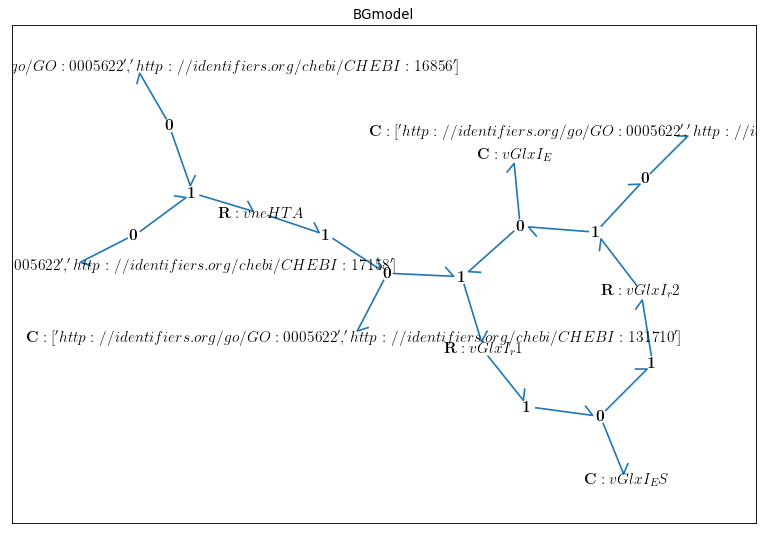

In [143]:
bgt.draw(BGmodel)

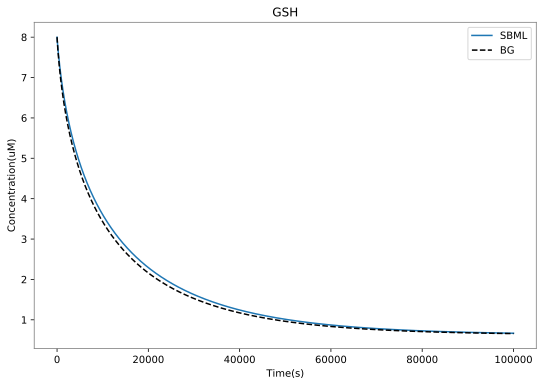

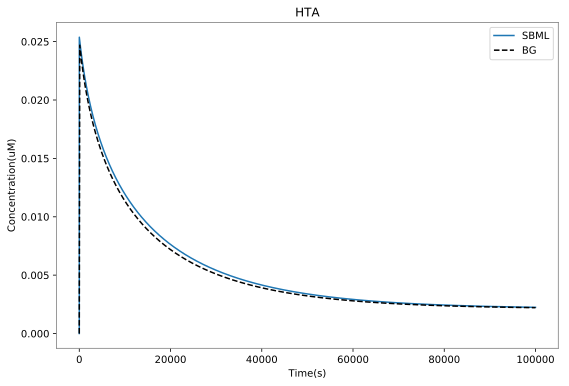

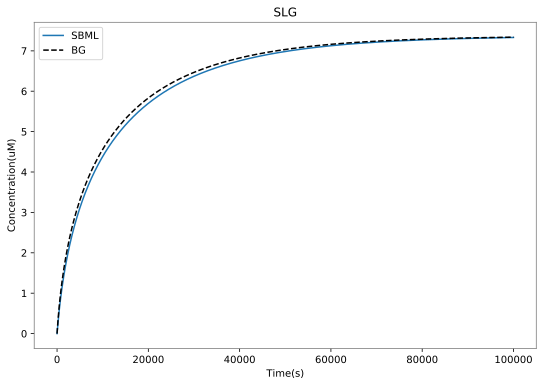

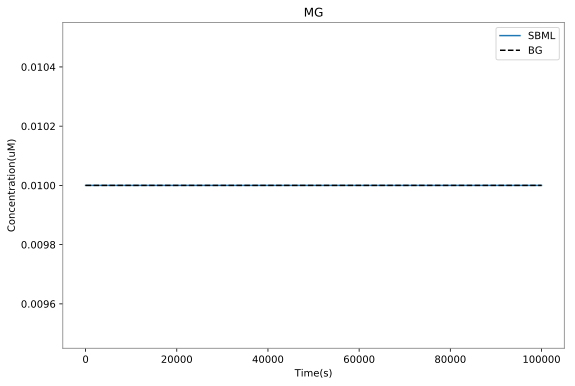

In [154]:
%config InlineBackend.figure_format = 'jpg'
rcParams['figure.figsize'] = 9, 6
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='grey')

font = font_manager.FontProperties(family='Times New Roman',
                                   weight='bold',
                                   style='normal', size=11)
plt.close('all')
for stateVar,i in zip(BGmodel.state_vars,range(len(BGmodel.state_vars))): 
    for key in idAndAnnotationsAll:
        for ids in idAndAnnotationsAll[key]:
            if str(BGmodel.state_vars[stateVar][0].name) == str(idAndAnnotationsAll[key][ids]):

                plt.figure()
                plt.title(ids)
                plt.plot(solutionsAll[key]['Time'],solutionsAll[key][ids],label='SBML')
                plt.plot(t,x[:,i],'k--',label='BG')
                plt.legend(loc='best')
                plt.ylabel('Concentration(uM)')
                plt.xlabel('Time(s)')


            